# pyiron: First steps

This section gives a brief introduction about fundamental concepts of pyiron and how they can be used to setup, run and analyze atomic simulations. 

As a first step we import pyiron as well as numpy for data analysis and matplotlib for visualization.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

from pyiron.project import Project

C:\Users\neugebauer\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The Project object is central in pyiron. It allows to name the project as well as to derive all other objects such as structures, jobs etc. without having to import them. Thus by code completion *Tab* the respective commands can be easily found:

In [27]:
pr = Project('first_steps')
basis = pr.create_ase_bulk('Al', cubic=True)
basis_3x3x3 = basis.repeat([3, 3, 3])
basis_3x3x3.plot3d()

A Jupyter Widget

The above script creates a project directory named 'first_steps'. *create_ase_bulk* uses the ASE bulk module to construct an Al fcc crystal in a cubic supercell (*cubic=True*). The structure can be modified - here we extend the original cell to a 3x3x3 supercell (*repeat([3, 3, 3]*). Finally, we plot the structure.

## Perform a Lammps MD simulation

Similar like for the atomic structure the project object allows to construct various simulation jobs. Here we create a Lammps job. We specify a Molecular Dynamics simulation at T=800 K. To see all available potentials which are compatible to the structure (for our example they must contain Al) and the job type (here Lammps) we call *ham.list_potentials()*.

In [3]:
ham = pr.create_job(job_type=pr.job_type.Lammps, job_name='Al_T800K')
ham.structure = basis_3x3x3
ham.calc_md(temperature=300, n_ionic_steps=10000)
ham.list_potentials()

['Al_lammps_eam',
 'Al_lammps_2_eam',
 'AlAg_lammps_eam',
 'CuAl_lammps_eam',
 'ZrAl_lammps_eam',
 'ZrCuAl_lammps_eam',
 'Al_Fe_eam_fs',
 'Al_LEA_eam_alloy',
 'MDSL_eam_fs',
 'Al1_eam_fs',
 'mg_al_set_eam_alloy',
 'Al_Mg_eam_fs',
 'alpb_setfl_eam_alloy',
 'Al90Sm10_MendelevM_2014_eam_fs',
 'Al99_eam_alloy',
 'Al03_eam_alloy',
 'Fictional_Al1_1_eam_fs',
 'Fictional_Al1_2_eam_fs',
 'Fictional_Al1_3_eam_fs',
 'Farkas_Nb_Ti_Al_1996_eam_alloy',
 'NiAl02_eam_alloy',
 'Mishin_Al_Co_2013_eam_alloy',
 'Mishin_Ni_Al_Co_2013_eam_alloy',
 'Mishin_updated_Al_Co_2013_eam_alloy',
 'Mishin_updated_Ni_Al_Co_2013_eam_alloy',
 'NiAlH_jea_eam_alloy',
 'NiAl_eam_alloy',
 'Mishin_Ni_Al_2009_eam_alloy',
 'Zope_Ti_Al_2003_eam_alloy']

From the above let us we select the first potential.

In [4]:
pot = ham.list_potentials()[0]
print ('select potential ', pot)
ham.potential = pot
ham.run()

select potential  Al_lammps_eam


## Analyse the calculation

Show the available jobs in the current project:

In [5]:
pr

['Al_T800K', 'Al_T200K', 'Al_T400K', 'Al_T600K', 'Al_T1000K']

The list shows the (only) job computed so far. To access it we can write:

In [6]:
ham = pr['Al_T800K']
ham

{'groups': ['output', 'input'], 'nodes': ['NAME', 'VERSION', 'server', 'TYPE']}

Printing the job object (note that in Jupyter we don't have to call a print statement if the variable/object is in the last line). The output lists the variables (nodes) and the directories (groups). To get a list of all variables stored in the generic output we type:

In [7]:
ham['output/generic']

{'groups': [], 'nodes': ['cells', 'steps', 'time', 'unwrapped_positions', 'energy_pot', 'energy_tot', 'forces', 'volume', 'positions', 'pressures', 'temperatures']}

An animated 3d plot of the MD trajectories is created by:

In [8]:
ham.animate_structure()

A Jupyter Widget

To analyze the temperature evolution we plot it as function of the MD step:

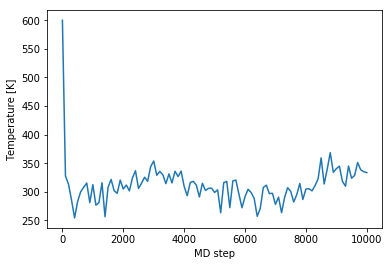

In [9]:
temperatures = ham['output/generic/temperatures']
steps = ham['output/generic/steps']
plt.plot(steps, temperatures)
plt.xlabel('MD step')
plt.ylabel('Temperature [K]');

In the same way we can plot the trajectories:

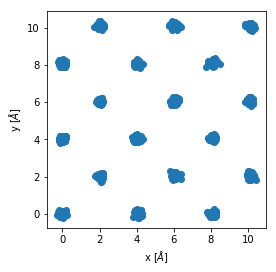

In [10]:
pos = ham['output/generic/positions']
x, y, z = [pos[:, :, i] for i in range(3)]
sel = np.abs(z) < 0.1
fig, axs = plt.subplots(1,1)
axs.scatter(x[sel], y[sel])
axs.set_xlabel('x [$\AA$]')
axs.set_ylabel('y [$\AA$]')
axs.set_aspect('equal', 'box');

## Perform a series of jobs

As a simple example we will reuse the hamilton generated in the last excercise, run it for various temperatures in a NPT ensamble and use the data to plot thermal expansion.

In [11]:
for temperature in np.arange(200, 1200, 200):
    ham = pr.create_job(pr.job_type.Lammps, 'Al_T{}K'.format(int(temperature)))
    ham.structure = basis_3x3x3
    ham.potential = pot                
    ham.calc_md(temperature=temperature, pressure=0, n_ionic_steps=10000)
    ham.run()

To inspect the list of jobs in our current project we type (note that the existing job from the previous excercise at 800K has been recognized and not run again):

In [12]:
pr

['Al_T800K', 'Al_T200K', 'Al_T400K', 'Al_T600K', 'Al_T1000K']

We can now iterate over the jobs and extract volume and mean temperature:

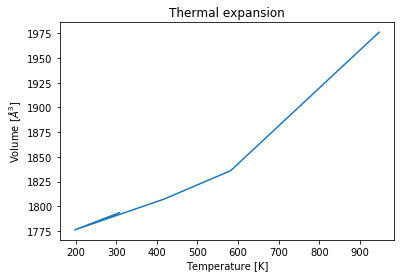

In [13]:
vol_lst, temp_lst = [], []
for ham in pr.iter_jobs(convert_to_object=False):
    volumes = ham['output/generic/volume']
    temperatures = ham['output/generic/temperatures']
    temp_lst.append(np.mean(temperatures[:-20]))
    vol_lst.append(np.mean(volumes[:-20]))
plt.plot(temp_lst, vol_lst)
plt.title('Thermal expansion')
plt.xlabel('Temperature [K]')
plt.ylabel('Volume [$\AA^3$]');

## Create a series of projects

We extend the previous example and compute the thermal expansion for all available Al potentials.

In [25]:
pr = Project('Al_potentials')
pot_lst = pr['../first_steps/Al_T200K'].load_object().list_potentials()[:3]
for pot in pot_lst:
    print (pot)
    pr_pot = pr.create_group(pot)
    for temperature in np.arange(200, 1200, 200):
        ham = pr_pot.create_job(pr.job_type.Lammps, 'Al_T{}K'.format(int(temperature)))
        ham.structure = basis_3x3x3
        ham.potential = pot                
        ham.calc_md(temperature=temperature, pressure=0, n_ionic_steps=10000)
        ham.run()

Al_lammps_eam
Al_lammps_2_eam
AlAg_lammps_eam


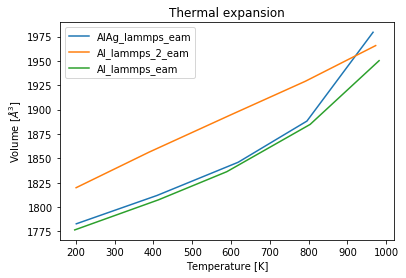

In [22]:
for p in pr.iter_groups():
    vol_lst, temp_lst = [], []
    for out in p.iter_jobs(path='output/generic'):
        volumes = out['volume']
        temperatures = out['temperatures']
        temp_lst.append(np.mean(temperatures[:-20]))
        vol_lst.append(np.mean(volumes[:-20]))
    plt.plot(temp_lst, vol_lst, label=p.name) 
plt.legend()    
plt.title('Thermal expansion')
plt.xlabel('Temperature [K]')
plt.ylabel('Volume [$\AA^3$]');